In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../img"

In [10]:
img2 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img2.jpg'))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img2.jpg'),0)

tri2 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri2.jpg'),0)

print(img2.shape)
print(tri2.shape)

(1920, 1280, 3)
(1920, 1280)


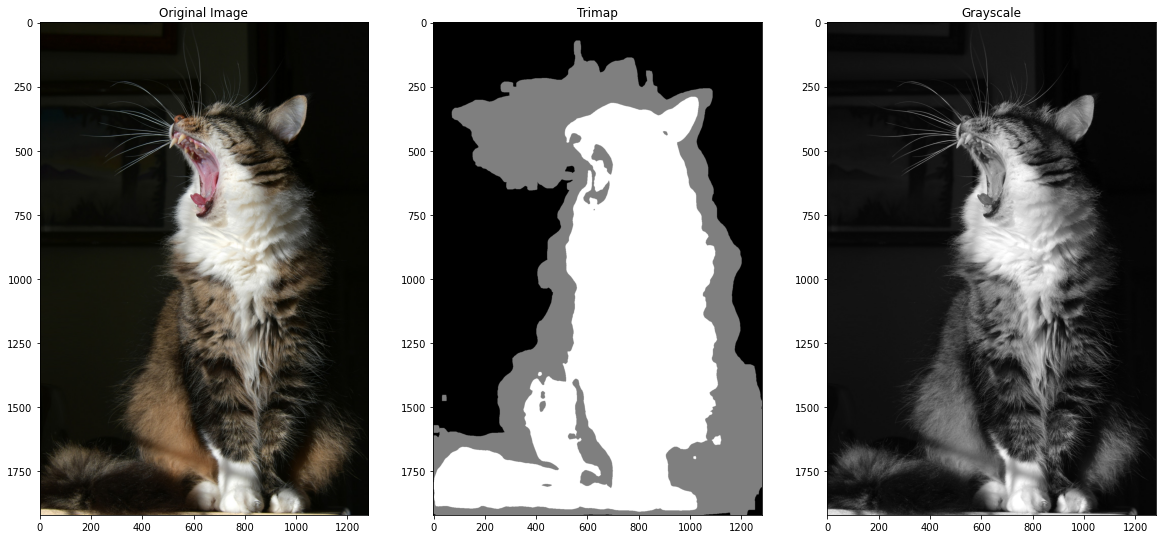

In [11]:
plt.figure(figsize = (20,15))

plt.subplot(131)
plt.imshow(img2)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(tri2,cmap='gray')
plt.title('Trimap')
plt.subplot(133)
plt.imshow(img2_gray,cmap='gray')
plt.title('Grayscale')
plt.show()

(1920, 1280, 3)


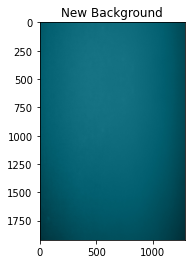

In [16]:
new_bg2 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg2.jpg'))
new_bg2 = cv2.cvtColor(new_bg2, cv2.COLOR_BGR2RGB)

new_bg2 = np.rot90(new_bg2)

print(new_bg2.shape)
plt.imshow(new_bg2)
plt.title('New Background')
plt.show()

# Global Matting

In [19]:
mask_bg = (tri2<10)
mask_fg = (tri2>245)
# mask_unknown = (np.bitwise_and(tri1>=10,tri1<=245))

mask_unknown = True ^ (mask_bg+mask_fg)

fg = img2_gray*(mask_fg)
bg = img2_gray*(mask_bg)
unknown = img2_gray*mask_unknown

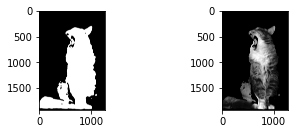

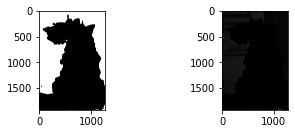

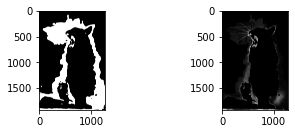

In [20]:
plt.subplot(221)
plt.imshow(mask_fg,cmap='gray')
plt.subplot(222)
plt.imshow(fg,cmap='gray')
plt.show()

plt.subplot(221)
plt.imshow(mask_bg,cmap='gray')
plt.subplot(222)
plt.imshow(bg,cmap='gray')
plt.show()

plt.subplot(221)
plt.imshow(mask_unknown,cmap='gray')
plt.subplot(222)
plt.imshow(unknown,cmap='gray')
plt.show()

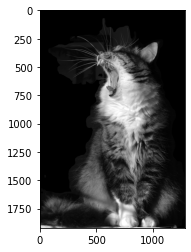

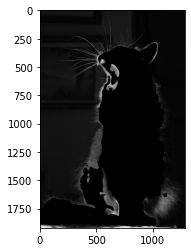

In [21]:
F = img2_gray*(mask_fg+mask_unknown)
B = img2_gray*(mask_bg+mask_unknown)

diff = F-B
diff = np.maximum(diff,0)
diff = np.minimum(diff,255)

plt.imshow(F,cmap='gray')
plt.show()
plt.imshow(B,cmap='gray')
plt.show()
# IF possible add a personal Gaussian filter in the next line
# diff = cv2.GaussianBlur(diff,(5,5),cv2.BORDER_DEFAULT)

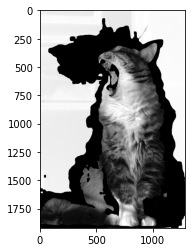

In [22]:

plt.imshow(diff,cmap='gray')
plt.show()

# diff = ndimage.filters.gaussian_filter(diff, 0.9)
# diff = np.maximum(diff,0)
# diff = np.minimum(diff,255)
# plt.imshow(diff,cmap='gray')
# plt.show()


In [23]:
grad_y,grad_x = np.gradient(img2_gray)

# ###################### Doubtful line
diff[diff==0] = 1

d2y_alpha, _ = np.gradient(grad_y/diff)
_, d2x_alpha = np.gradient(grad_x/diff)

In [24]:
d2alpha = d2y_alpha + d2x_alpha

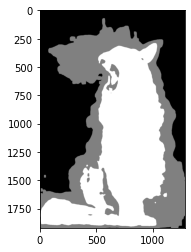

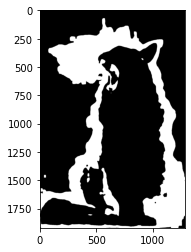

In [25]:
estimate_alpha = mask_fg + 0.5*mask_unknown
plt.imshow(estimate_alpha,cmap='gray')
plt.show()

plt.imshow(mask_unknown,cmap='gray')
plt.show()

In [26]:
def alpha_matting(alpha,d2alpha,unknown_seg,num_iterations = 75, threshold = 0.2, beta = 1):
    old_alpha = np.zeros(alpha.shape)
    new_alpha = alpha.copy()
    h,w = alpha.shape
    
    change = np.sum(np.abs(old_alpha-new_alpha))
    
    for _ in range(num_iterations):
        change = np.sum(np.abs(old_alpha-new_alpha))
        if change < threshold:
            break
        for i in range(1,h-1,1):
            for j in range(1,w-1,1):
                if unknown_seg[i,j]:
                    new_alpha[i,j] = ((beta*(new_alpha[i,j-1]+new_alpha[i-1,j]+old_alpha[i,j+1]+old_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*old_alpha[i,j])
                        
    return new_alpha

In [27]:
alpha_optimal = alpha_matting(estimate_alpha,d2alpha,mask_unknown,num_iterations = 50, threshold = 0.3, beta = 1.5)

alpha_optimal = np.maximum(alpha_optimal,0)
alpha_optimal = np.minimum(alpha_optimal,1)

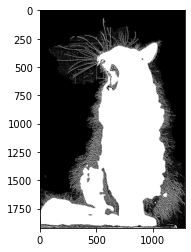

In [29]:
plt.imshow(alpha_optimal,cmap='gray')
plt.show()


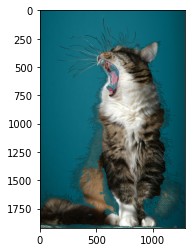

In [30]:
alpha_optimal = np.int64(alpha_optimal)
alpha_optimal = alpha_optimal/np.max(alpha_optimal)
new_img = np.zeros(new_bg2.shape)
new_img[:,:,0] = alpha_optimal*img2[:,:,0] + (1-alpha_optimal)*new_bg2[:,:,0]
new_img[:,:,1] = alpha_optimal*img2[:,:,1] + (1-alpha_optimal)*new_bg2[:,:,1]
new_img[:,:,2] = alpha_optimal*img2[:,:,2] + (1-alpha_optimal)*new_bg2[:,:,2]

plt.imshow(np.int64(new_img),cmap='gray')
plt.show()